In [1]:
from data_loader import get_data_loader
from metrics_utility import MetricsCalculator
from torch import nn
import torch.nn.functional as F
import torch
import segmentation_models_pytorch as smp
import itertools
import pandas as pd
import os

/usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = (
    torch.accelerator.current_accelerator().type
    if torch.accelerator.is_available()
    else "cpu"
)

In [3]:
matrics_df = pd.DataFrame(
    columns=[
        "id",
        "fold",
        "iou",
        "error_cm",
        "error_0_5cm",
        "error_1cm",
    ]
)
matrics_df = pd.read_csv("/workspaces/hw3_B11023038/model/metrics_arch_bce.csv")

In [ ]:
for i in os.listdir("/workspaces/hw3_B11023038/model"):
    fold  = i.split("_")[-2]
    _, _, test = get_data_loader(
        f"/workspaces/hw3_B11023038/ETT-v3/Fold{fold}",
        shuffle=False,
        batch_size=8,
        num_workers=4,
        preprocess_fn=lambda x: x / 255.0,
    )
    model = smp.from_pretrained(f"/workspaces/hw3_B11023038/model/{i}").to(device)
    model.eval()
    mc = MetricsCalculator(72, 7)
    with torch.no_grad():
        for _, (tinputs, tlabels) in enumerate(test):
            assert len(tinputs) == len(tlabels)
            tinputs = tinputs.to(device, dtype=torch.float)
            tlabels = tlabels.to(device)
            toutputs = model(tinputs)
            mc(toutputs, tlabels)
    del model
    metrics = mc.compute()
    matrics_df = pd.concat(
        [
            matrics_df,
            pd.DataFrame(
                {
                    "id": [i[:-4]],
                    "fold": [fold],
                    "iou": [metrics["iou"]],
                    "error_cm": [metrics["error_cm"]],
                    "error_0_5cm": [metrics["error_0_5cm"]],
                    "error_1cm": [metrics["error_1cm"]],
                }
            ),
        ],
        ignore_index=True,
    )
matrics_df.to_csv("/workspaces/hw3_B11023038/model/metrics_arch_bce.csv", index=False)

In [25]:
iou_df = matrics_df.groupby("id")[["iou", "error_cm"]].mean().reset_index().round(3)[["id", "iou"]]
# err_cm_df = matrics_df.groupby("id")["error_cm"].mean().reset_index()
iou_df

,id,iou
0,UnetPlusPlus_resnet50_bce,0.677
1,UnetPlusPlus_timm-regnetx_064_bce,0.705
2,UnetPlusPlus_timm-regnety_064_bce,0.690
3,Unet_resnet50_bce,0.648
4,Unet_timm-regnetx_064_bce,0.704
5,Unet_timm-regnety_064_bce,0.712


In [19]:
matrics_df.pivot(columns="fold", index="id").round(3)

iou                             error_cm  \
fold                                   1      2      3      4      5        1   
id                                                                              
UnetPlusPlus_resnet50_bce          0.772  0.687  0.639  0.624  0.661    0.689   
UnetPlusPlus_timm-regnetx_064_bce  0.775  0.742  0.675  0.673  0.658    0.441   
UnetPlusPlus_timm-regnety_064_bce  0.741  0.703  0.643  0.708  0.654    0.736   
Unet_resnet50_bce                  0.704  0.691  0.603  0.610  0.630    0.563   
Unet_timm-regnetx_064_bce          0.768  0.732  0.648  0.676  0.697    0.418   
Unet_timm-regnety_064_bce          0.773  0.751  0.669  0.688  0.680    0.590   

                                                              error_0_5cm  \
fold                                   2      3      4      5           1   
id                                                                          
UnetPlusPlus_resnet50_bce          0.503  1.251  0.798  0.717      48.936   
UnetPlusPlus_timm-regnetx_064_bce  0.556  1.136  0.952  0.881      68.085   
UnetPlusPlus_timm-regnety_064_bce  0.697  1.386  1.037  0.855      55.319   
Unet_resnet50_bce                  1.020  1.717  1.021  0.731      63.830   
Unet_timm-regnetx_064_bce          0.829  1.160  0.790  0.656      74.468   
Unet_timm-regnety_064_bce          0.546  1.057  0.778  0.600      65.957   

                                                                  error_1cm  \
fold                                    2       3       4       5         1   
id                                                                            
UnetPlusPlus_resnet50_bce          57.447  51.064  54.167  41.667    87.234   
UnetPlusPlus_timm-regnetx_064_bce  63.830  51.064  52.083  50.000    87.234   
UnetPlusPlus_timm-regnety_064_bce  51.064  40.426  45.833  52.083    78.723   
Unet_resnet50_bce                  46.809  25.532  50.000  50.000    76.596   
Unet_timm-regnetx_064_bce          57.447  46.809  56.250  54.167    95.745   
Unet_timm-regnety_064_bce          63.830  44.681  56.250  60.417    93.617   

                                                                   
fold                                    2       3       4       5  
id                                                                 
UnetPlusPlus_resnet50_bce          89.362  57.447  75.000  79.167  
UnetPlusPlus_timm-regnetx_064_bce  87.234  70.213  68.750  75.000  
UnetPlusPlus_timm-regnety_064_bce  85.106  57.447  58.333  72.917  
Unet_resnet50_bce                  72.340  40.426  62.500  81.250  
Unet_timm-regnetx_064_bce          82.979  63.830  72.917  81.250  
Unet_timm-regnety_064_bce          82.979  59.574  77.083  83.333

In [33]:
matrics_df.groupby("id").mean().round(3)

,fold,iou,error_cm,error_0_5cm,error_1cm
id,,,,,
UnetPlusPlus_resnet50_bce,3.0,0.677,0.792,50.656,77.642
UnetPlusPlus_timm-regnetx_064_bce,3.0,0.705,0.793,57.012,77.686
UnetPlusPlus_timm-regnety_064_bce,3.0,0.690,0.942,48.945,70.505
Unet_resnet50_bce,3.0,0.648,1.010,47.234,66.622
Unet_timm-regnetx_064_bce,3.0,0.704,0.771,57.828,79.344
Unet_timm-regnety_064_bce,3.0,0.712,0.714,58.227,79.317


In [26]:
metrics_diff_loss_df = pd.read_csv("metrics_diff_loss.csv")

In [31]:
metrics_diff_loss_df.groupby("id").mean().round(3)

,fold,iou,error_cm,error_0_5cm,error_1cm,loss
id,,,,,,
Unet_timm-regnety_064_dice,3.0,0.724,0.718,57.819,81.055,0.164
Unet_timm-regnety_064_focal,3.0,0.601,0.913,52.713,75.505,0.008


In [34]:
metrics_diff_loss_df

,id,fold,iou,error_cm,error_0_5cm,error_1cm,loss
0,Unet_timm-regnety_064_dice,1,0.779906,0.618499,68.085106,89.361702,0.125736
1,Unet_timm-regnety_064_dice,2,0.756361,0.504728,57.446809,91.489362,0.140770
2,Unet_timm-regnety_064_dice,3,0.690582,0.866726,51.063830,72.340426,0.189481
3,Unet_timm-regnety_064_dice,4,0.693996,0.773727,60.416667,72.916667,0.183819
4,Unet_timm-regnety_064_dice,5,0.697077,0.826389,52.083333,79.166667,0.180940
5,Unet_timm-regnety_064_focal,1,0.712743,0.498522,63.829787,91.489362,0.006832
6,Unet_timm-regnety_064_focal,2,0.584324,0.783983,59.574468,74.468085,0.005952
7,Unet_timm-regnety_064_focal,3,0.444556,1.735520,27.659574,55.319149,0.010367
8,Unet_timm-regnety_064_focal,4,0.654513,0.907407,41.666667,70.833333,0.009041
9,Unet_timm-regnety_064_focal,5,0.606722,0.638021,70.833333,85.416667,0.008751


Loading weights from local directory


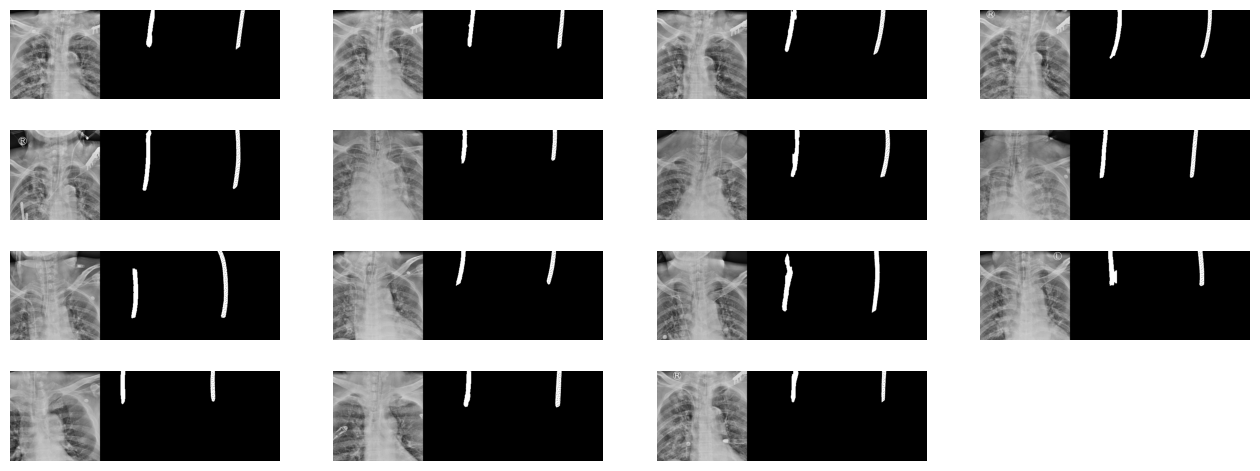

In [3]:
from metrics_utility import post_process
import matplotlib.pyplot as plt
import numpy as np    


test_model = smp.from_pretrained("/workspaces/hw3_B11023038/model/Unet_timm-regnety_064_dice_1_0").to(device)
test_model.eval()
_, _, test = get_data_loader(
    f"/workspaces/hw3_B11023038/ETT-v3/Fold1",
    shuffle=False,
    batch_size=16,
    num_workers=4,
    preprocess_fn=lambda x: x / 255.0,
)

with torch.no_grad():
    for i, (tinputs, tlabels) in enumerate(test):
        tinputs = tinputs.to(device, dtype=torch.float)
        tlabels = tlabels.to(device)
        toutputs = test_model(tinputs)

tinputs = tinputs.cpu().numpy()*255
toutputs, tlabels = post_process(toutputs, tlabels)

plt.figure(figsize = (16, 6))
for i in range(15):
    plt.subplot(4, 4, i + 1)
    plt.imshow(np.concatenate((tinputs[i][0], toutputs[i][0], tlabels[i][0]), axis=1), cmap='gray')
    plt.axis('off')

In [4]:
from data_aug import data_aug

(-0.5, 223.5, 223.5, -0.5)

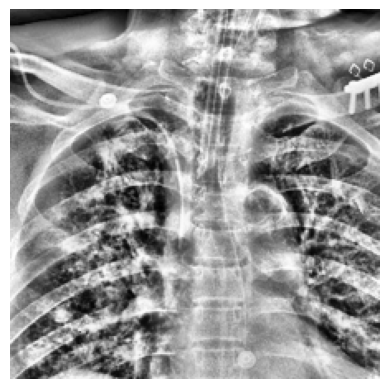

In [5]:
x, _ = data_aug(tinputs[0][0].astype(np.uint8), tlabels[0][0]==255)

(-0.5, 223.5, 223.5, -0.5)

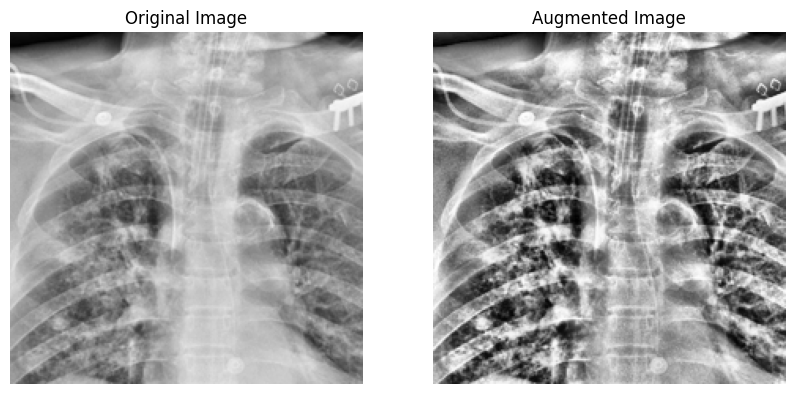

In [9]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(tinputs[0][0].astype(np.uint8), cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(x, cmap='gray')
plt.title("Augmented Image")
plt.axis('off')